# Unit08_FP_Growth_Algorithm | 關聯規則學習：FP-Growth 演算法

本 Notebook 使用模擬的聚合物配方數據，示範如何使用 FP-Growth 演算法進行關聯規則挖掘，並與 Apriori 演算法進行性能比較。

## 目標
- 理解 FP-Growth 演算法的工作原理與 FP-Tree 資料結構
- 學會使用 mlxtend 套件實作 FP-Growth
- 從化工配方數據中快速發現頻繁項目集與關聯規則
- 比較 FP-Growth 與 Apriori 的性能差異
- 評估和解讀關聯規則
- 視覺化關聯規則網絡與性能比較

資料背景：模擬的聚合物配方數據，包含單體、引發劑、鏈轉移劑、溶劑、溫度、時間等變數，以及產品品質指標（分子量分布、轉化率、純度）。本範例將使用大規模數據集（50,000 筆配方）以展示 FP-Growth 的性能優勢。

---
### 0. 環境設定

In [1]:
from pathlib import Path
import os

# ========================================
# 路徑設定 (兼容 Colab 與 Local)
# ========================================
UNIT_OUTPUT_DIR = 'P2_Unit08_FP_Growth_Algorithm'
SOURCE_DATA_DIR = 'polymer_formulations'

try:
  from google.colab import drive
  IN_COLAB = True
  print("✓ 偵測到 Colab 環境，準備掛載 Google Drive...")
  drive.mount('/content/drive', force_remount=True)
except ImportError:
  IN_COLAB = False
  print("✓ 偵測到 Local 環境")
try:
  shortcut_path = '/content/CHE-AI-COURSE'
  os.remove(shortcut_path)
except FileNotFoundError:
  pass

if IN_COLAB:
  source_path = Path('/content/drive/My Drive/Colab Notebooks/CHE-AI-COURSE')
  os.symlink(source_path, shortcut_path)
  shortcut_path = Path(shortcut_path)
  if source_path.exists():
    NOTEBOOK_DIR = shortcut_path / 'Part_2' / 'Unit08'
    OUTPUT_DIR = NOTEBOOK_DIR / 'outputs' / UNIT_OUTPUT_DIR
    DATA_DIR = NOTEBOOK_DIR / 'data' / SOURCE_DATA_DIR
    FIG_DIR = OUTPUT_DIR / 'figs'
  else:
    print(f"⚠️ 找不到路徑雲端CHE-AI-COURSE路徑，請確認自己的雲端資料夾是否正確")
  
else:
  NOTEBOOK_DIR = Path.cwd()
  OUTPUT_DIR = NOTEBOOK_DIR / 'outputs' / UNIT_OUTPUT_DIR
  DATA_DIR = NOTEBOOK_DIR / 'data' / SOURCE_DATA_DIR
  FIG_DIR = OUTPUT_DIR / 'figs'

NOTEBOOK_DIR.mkdir(parents=True, exist_ok=True)
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
DATA_DIR.mkdir(parents=True, exist_ok=True)
FIG_DIR.mkdir(parents=True, exist_ok=True)

print(f"\n✓ Notebook工作目錄: {NOTEBOOK_DIR}")
print(f"✓ 數據來源目錄: {DATA_DIR}")
print(f"✓ 結果輸出目錄: {OUTPUT_DIR}")
print(f"✓ 圖檔輸出目錄: {FIG_DIR}")

✓ 偵測到 Local 環境

✓ Notebook工作目錄: d:\MyGit\CHE-AI-COURSE\Part_2\Unit08
✓ 數據來源目錄: d:\MyGit\CHE-AI-COURSE\Part_2\Unit08\data\polymer_formulations
✓ 結果輸出目錄: d:\MyGit\CHE-AI-COURSE\Part_2\Unit08\outputs\P2_Unit08_FP_Growth_Algorithm
✓ 圖檔輸出目錄: d:\MyGit\CHE-AI-COURSE\Part_2\Unit08\outputs\P2_Unit08_FP_Growth_Algorithm\figs


---
### 1. 載入相關套件

In [2]:
# 基礎套件
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import time
warnings.filterwarnings('ignore')

# Association Rule Mining 套件
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import fpgrowth, apriori, association_rules

# 網絡圖視覺化
import networkx as nx

# 設定隨機種子以確保結果可重現
SEED = 42
np.random.seed(SEED)

# 設定matplotlib中文顯示
plt.rcParams['axes.unicode_minus'] = False

print("✓ 套件載入完成")

✓ 套件載入完成


---
### 2. 生成大規模模擬聚合物配方數據

為了展示 FP-Growth 的性能優勢，我們生成一個大規模的聚合物配方數據集。

**數據特徵**：
- 50,000 筆配方記錄（比 Apriori 範例多 100 倍）
- 單體：Monomer A, B, C（3 種選擇）
- 引發劑：Initiator I1, I2, I3（3 種選擇）
- 鏈轉移劑：CT1, CT2, CT3（3 種選擇）
- 溶劑：Solvent S1, S2, S3（3 種選擇）
- 反應溫度：60-70°C, 70-80°C, 80-90°C（3 個範圍）
- 反應時間：2-4h, 4-6h, 6-8h（3 個範圍）
- 產品品質標籤：窄分子量分布、高純度、高轉化率（根據品質指標生成）

**數據生成策略**：
- 使用加權隨機抽樣，模擬實際配方中的常見組合
- 某些組合出現頻率較高（模擬成功配方）
- 品質標籤基於特定組合的協同效應

In [3]:
# 生成大規模聚合物配方數據
n_transactions = 50000  # 50,000 筆配方（增加規模以展示 FP-Growth 優勢）

# 定義配方成分選項
monomers = ['Monomer A', 'Monomer B', 'Monomer C']
initiators = ['Initiator I1', 'Initiator I2', 'Initiator I3']
chain_transfer = ['CT1', 'CT2', 'CT3']
solvents = ['Solvent S1', 'Solvent S2', 'Solvent S3']
temperatures = ['Temp_60-70', 'Temp_70-80', 'Temp_80-90']
times = ['Time_2-4h', 'Time_4-6h', 'Time_6-8h']

# 為常見組合設定權重（模擬實際配方偏好）
monomer_probs = [0.5, 0.3, 0.2]  # Monomer A 最常用
initiator_probs = [0.4, 0.4, 0.2]  # I1 和 I2 較常用
ct_probs = [0.5, 0.3, 0.2]  # CT1 最常用
solvent_probs = [0.4, 0.35, 0.25]  # S1 略常用
temp_probs = [0.25, 0.5, 0.25]  # 70-80°C 最常用
time_probs = [0.2, 0.6, 0.2]  # 4-6h 最常用

# 生成交易列表
transactions = []

for i in range(n_transactions):
    trans = []
    
    # 隨機選擇配方成分（使用加權抽樣）
    monomer = np.random.choice(monomers, p=monomer_probs)
    initiator = np.random.choice(initiators, p=initiator_probs)
    ct = np.random.choice(chain_transfer, p=ct_probs)
    solvent = np.random.choice(solvents, p=solvent_probs)
    temp = np.random.choice(temperatures, p=temp_probs)
    reaction_time = np.random.choice(times, p=time_probs)  # 改名為 reaction_time
    
    # 添加到交易
    trans.extend([monomer, initiator, ct, solvent, temp, reaction_time])
    
    # 根據特定組合添加品質標籤（模擬協同效應）
    
    # 窄分子量分布的條件
    if (monomer == 'Monomer A' and initiator == 'Initiator I2' and 
        temp == 'Temp_70-80' and reaction_time == 'Time_4-6h'):
        if np.random.rand() < 0.85:  # 85% 機率
            trans.append('Narrow_MW')
    
    # 高純度的條件
    if (ct == 'CT1' and solvent == 'Solvent S2'):
        if np.random.rand() < 0.78:  # 78% 機率
            trans.append('High_Purity')
    
    # 高轉化率的條件
    if (monomer == 'Monomer A' and temp in ['Temp_70-80', 'Temp_80-90']):
        if np.random.rand() < 0.70:  # 70% 機率
            trans.append('High_Conv')
    
    transactions.append(trans)

print(f"✓ 成功生成 {len(transactions)} 筆配方數據")
print(f"✓ 範例交易 1: {transactions[0]}")
print(f"✓ 範例交易 2: {transactions[1]}")
print(f"✓ 範例交易 3: {transactions[2]}")

✓ 成功生成 50000 筆配方數據
✓ 範例交易 1: ['Monomer A', 'Initiator I3', 'CT2', 'Solvent S2', 'Temp_60-70', 'Time_2-4h']
✓ 範例交易 2: ['Monomer A', 'Initiator I3', 'CT2', 'Solvent S2', 'Temp_60-70', 'Time_6-8h']
✓ 範例交易 3: ['Monomer C', 'Initiator I1', 'CT1', 'Solvent S1', 'Temp_70-80', 'Time_4-6h']


---
### 3. 數據轉換：交易格式 → One-Hot 編碼

FP-Growth 和 Apriori 都需要將交易列表轉換為 One-Hot 編碼格式。

In [4]:
# 使用 TransactionEncoder 轉換為 One-Hot 編碼
te = TransactionEncoder()
te_ary = te.fit(transactions).transform(transactions)
df = pd.DataFrame(te_ary, columns=te.columns_)

print("✓ 數據轉換完成")
print(f"✓ 資料形狀: {df.shape}")
print(f"✓ 項目總數: {df.shape[1]}")
print(f"\n前 5 筆交易的 One-Hot 編碼：")
print(df.head())

✓ 數據轉換完成
✓ 資料形狀: (50000, 21)
✓ 項目總數: 21

前 5 筆交易的 One-Hot 編碼：
     CT1    CT2    CT3  High_Conv  High_Purity  Initiator I1  Initiator I2  \
0  False   True  False      False        False         False         False   
1  False   True  False      False        False         False         False   
2   True  False  False      False        False          True         False   
3  False   True  False       True        False          True         False   
4  False   True  False      False        False          True         False   

   Initiator I3  Monomer A  Monomer B  ...  Narrow_MW  Solvent S1  Solvent S2  \
0          True       True      False  ...      False       False        True   
1          True       True      False  ...      False       False        True   
2         False      False      False  ...      False        True       False   
3         False       True      False  ...      False        True       False   
4         False      False       True  ...      False       Fals

---
### 4. 執行 FP-Growth 演算法並測量性能

使用 mlxtend 的 `fpgrowth()` 函數執行 FP-Growth 演算法，並同時測量執行時間。

In [5]:
# 設定最小支持度閾值
min_support = 0.02  # 2%，至少出現在 1000 筆配方中（降低閾值增加候選集）

# 執行 FP-Growth 演算法並測量時間
print("開始執行 FP-Growth 演算法...")
start_time_fpgrowth = time.time()

# 使用 use_colnames=False 保持數字索引（稍後用於生成規則）
frequent_itemsets_fpgrowth = fpgrowth(df, min_support=min_support, use_colnames=False)

end_time_fpgrowth = time.time()
fpgrowth_time = end_time_fpgrowth - start_time_fpgrowth

print(f"\n✓ FP-Growth 執行完成")
print(f"✓ 執行時間: {fpgrowth_time:.4f} 秒")
print(f"✓ 找到 {len(frequent_itemsets_fpgrowth)} 個頻繁項目集")

# 按支持度排序並顯示（將索引映射為列名以便閱讀）
frequent_itemsets_fpgrowth_sorted = frequent_itemsets_fpgrowth.copy()
frequent_itemsets_fpgrowth_sorted['itemsets_names'] = frequent_itemsets_fpgrowth_sorted['itemsets'].apply(
    lambda x: frozenset([df.columns[i] for i in x])
)
frequent_itemsets_fpgrowth_sorted = frequent_itemsets_fpgrowth_sorted.sort_values('support', ascending=False)

print(f"\n前 10 個最頻繁的項目集：")
print(frequent_itemsets_fpgrowth_sorted[['itemsets_names', 'support']].head(10))

開始執行 FP-Growth 演算法...

✓ FP-Growth 執行完成
✓ 執行時間: 0.3508 秒
✓ 找到 1175 個頻繁項目集

前 10 個最頻繁的項目集：
              itemsets_names  support
7                (Time_4-6h)  0.59918
8               (Temp_70-80)  0.50036
0                (Monomer A)  0.49968
9                      (CT1)  0.49860
10              (Solvent S1)  0.40094
11            (Initiator I1)  0.39960
18            (Initiator I2)  0.39954
1               (Solvent S2)  0.34964
2                      (CT2)  0.30142
406  (Time_4-6h, Temp_70-80)  0.30012


---
### 5. 執行 Apriori 演算法進行性能比較

使用相同的數據集和支持度閾值執行 Apriori 演算法，比較兩者的性能差異。

In [6]:
# 執行 Apriori 演算法並測量時間
print("開始執行 Apriori 演算法...")
start_time_apriori = time.time()

# 同樣使用 use_colnames=False 保持一致
frequent_itemsets_apriori = apriori(df, min_support=min_support, use_colnames=False)

end_time_apriori = time.time()
apriori_time = end_time_apriori - start_time_apriori

print(f"\n✓ Apriori 執行完成")
print(f"✓ 執行時間: {apriori_time:.4f} 秒")
print(f"✓ 找到 {len(frequent_itemsets_apriori)} 個頻繁項目集")

# 性能比較
speedup = apriori_time / fpgrowth_time
print(f"\n{'='*60}")
print(f"性能比較摘要")
print(f"{'='*60}")
print(f"數據規模: {len(transactions)} 筆配方")
print(f"項目數: {df.shape[1]}")
print(f"最小支持度: {min_support}")
print(f"-" * 60)
print(f"FP-Growth 執行時間: {fpgrowth_time:.4f} 秒")
print(f"Apriori 執行時間:   {apriori_time:.4f} 秒")
print(f"-" * 60)
print(f"加速比: {speedup:.2f}×")
print(f"FP-Growth 比 Apriori 快 {speedup:.2f} 倍")
print(f"{'='*60}")

# 驗證兩者結果是否相同（使用數字索引比較）
itemsets_fp = set(frequent_itemsets_fpgrowth['itemsets'])
itemsets_ap = set(frequent_itemsets_apriori['itemsets'])
print(f"\n✓ 結果驗證: 兩種演算法找到的頻繁項目集{'完全相同' if itemsets_fp == itemsets_ap else '不同'}")

開始執行 Apriori 演算法...

✓ Apriori 執行完成
✓ 執行時間: 1.0533 秒
✓ 找到 1175 個頻繁項目集

性能比較摘要
數據規模: 50000 筆配方
項目數: 21
最小支持度: 0.02
------------------------------------------------------------
FP-Growth 執行時間: 0.3508 秒
Apriori 執行時間:   1.0533 秒
------------------------------------------------------------
加速比: 3.00×
FP-Growth 比 Apriori 快 3.00 倍

✓ 結果驗證: 兩種演算法找到的頻繁項目集完全相同


---
### 6. 從頻繁項目集生成關聯規則

使用 FP-Growth 找到的頻繁項目集生成關聯規則，並篩選出與產品品質相關的規則。

In [7]:
# 從頻繁項目集生成關聯規則
min_confidence = 0.6  # 60% 置信度

# 使用數字索引生成規則（避免 mlxtend 的 bug）
rules = association_rules(
    frequent_itemsets_fpgrowth, 
    metric="confidence", 
    min_threshold=min_confidence
)

print(f"✓ 成功生成 {len(rules)} 條關聯規則")

# 將規則中的數字索引映射回列名以便閱讀
def map_indices_to_names(itemset):
    return frozenset([df.columns[i] for i in itemset])

rules['antecedents'] = rules['antecedents'].apply(map_indices_to_names)
rules['consequents'] = rules['consequents'].apply(map_indices_to_names)

# 篩選出後項包含品質標籤的規則
quality_labels = ['Narrow_MW', 'High_Purity', 'High_Conv']
quality_rules = rules[
    rules['consequents'].apply(
        lambda x: any(label in x for label in quality_labels)
    )
]

print(f"✓ 其中 {len(quality_rules)} 條規則與產品品質相關")

# 按 lift 排序，找出最有價值的規則
quality_rules_sorted = quality_rules.sort_values('lift', ascending=False)

print(f"\n前 10 條最有價值的品質相關規則（按 Lift 排序）：")
print(quality_rules_sorted[['antecedents', 'consequents', 'support', 'confidence', 'lift']].head(10))

✓ 成功生成 1122 條關聯規則
✓ 其中 181 條規則與產品品質相關

前 10 條最有價值的品質相關規則（按 Lift 排序）：
                                            antecedents  \
1042  (Solvent S1, Monomer A, Initiator I2, Temp_70-...   
925                                         (Narrow_MW)   
989                                         (Narrow_MW)   
986                              (Monomer A, Narrow_MW)   
912    (Initiator I2, Time_4-6h, High_Conv, Temp_70-80)   
965    (Initiator I2, Time_4-6h, High_Conv, Temp_70-80)   
958   (Monomer A, Initiator I2, High_Conv, Temp_70-8...   
827    (Initiator I2, Time_4-6h, Monomer A, Temp_70-80)   
971    (Initiator I2, Time_4-6h, Monomer A, Temp_70-80)   
1108  (Monomer A, Initiator I2, Temp_70-80, Time_4-6...   

                                            consequents  support  confidence  \
1042                                        (Narrow_MW)  0.02010    0.856777   
925    (Initiator I2, Time_4-6h, High_Conv, Temp_70-80)  0.03532    0.715849   
989   (Monomer A, Initiator I2, High_Conv

---
### 7. 詳細分析特定品質目標的規則

分別分析三種品質標籤（窄分子量分布、高純度、高轉化率）的關聯規則。

In [8]:
# 分析三種品質目標的規則
quality_targets = {
    'Narrow_MW': '窄分子量分布',
    'High_Purity': '高純度',
    'High_Conv': '高轉化率'
}

for target, target_name in quality_targets.items():
    print(f"\n{'='*80}")
    print(f"品質目標: {target_name} ({target})")
    print(f"{'='*80}")
    
    # 篩選該品質目標的規則
    target_rules = quality_rules[
        quality_rules['consequents'].apply(lambda x: target in x)
    ].sort_values('lift', ascending=False)
    
    print(f"找到 {len(target_rules)} 條相關規則")
    
    if len(target_rules) > 0:
        print(f"\n前 3 條最強規則：")
        top_rules = target_rules.head(3)
        
        for idx, rule in top_rules.iterrows():
            antecedent = ', '.join(list(rule['antecedents']))
            consequent = ', '.join(list(rule['consequents']))
            print(f"\n規則 {idx + 1}:")
            print(f"  如果使用: {antecedent}")
            print(f"  則可獲得: {consequent}")
            print(f"  支持度: {rule['support']:.4f} ({rule['support']*100:.2f}%)")
            print(f"  置信度: {rule['confidence']:.4f} ({rule['confidence']*100:.2f}%)")
            print(f"  提升度: {rule['lift']:.4f}")
            print(f"  解讀: 相比隨機情況，使用此配方組合可將獲得{target_name}的機率提升 {rule['lift']:.2f} 倍")


品質目標: 窄分子量分布 (Narrow_MW)
找到 7 條相關規則

前 3 條最強規則：

規則 1043:
  如果使用: Solvent S1, Monomer A, Initiator I2, Temp_70-80, Time_4-6h
  則可獲得: Narrow_MW
  支持度: 0.0201 (2.01%)
  置信度: 0.8568 (85.68%)
  提升度: 17.3648
  解讀: 相比隨機情況，使用此配方組合可將獲得窄分子量分布的機率提升 17.36 倍

規則 913:
  如果使用: Initiator I2, Time_4-6h, High_Conv, Temp_70-80
  則可獲得: Narrow_MW
  支持度: 0.0353 (3.53%)
  置信度: 0.8511 (85.11%)
  提升度: 17.2494
  解讀: 相比隨機情況，使用此配方組合可將獲得窄分子量分布的機率提升 17.25 倍

規則 959:
  如果使用: Monomer A, Initiator I2, High_Conv, Temp_70-80, Time_4-6h
  則可獲得: Narrow_MW
  支持度: 0.0353 (3.53%)
  置信度: 0.8511 (85.11%)
  提升度: 17.2494
  解讀: 相比隨機情況，使用此配方組合可將獲得窄分子量分布的機率提升 17.25 倍

品質目標: 高純度 (High_Purity)
找到 34 條相關規則

前 3 條最強規則：

規則 763:
  如果使用: Solvent S2, High_Conv, Temp_70-80, CT1
  則可獲得: High_Purity, Monomer A
  支持度: 0.0237 (2.37%)
  置信度: 0.7834 (78.34%)
  提升度: 11.7445
  解讀: 相比隨機情況，使用此配方組合可將獲得高純度的機率提升 11.74 倍

規則 709:
  如果使用: Time_4-6h, Solvent S2, High_Conv, CT1
  則可獲得: High_Purity, Monomer A
  支持度: 0.0211 (2.11%)
  置信度: 0.7831 (78.31%)
 

---
### 8. 視覺化：性能比較

繪製 FP-Growth 與 Apriori 的性能比較圖。

✓ 圖檔已儲存: d:\MyGit\CHE-AI-COURSE\Part_2\Unit08\outputs\P2_Unit08_FP_Growth_Algorithm\figs\performance_comparison.png


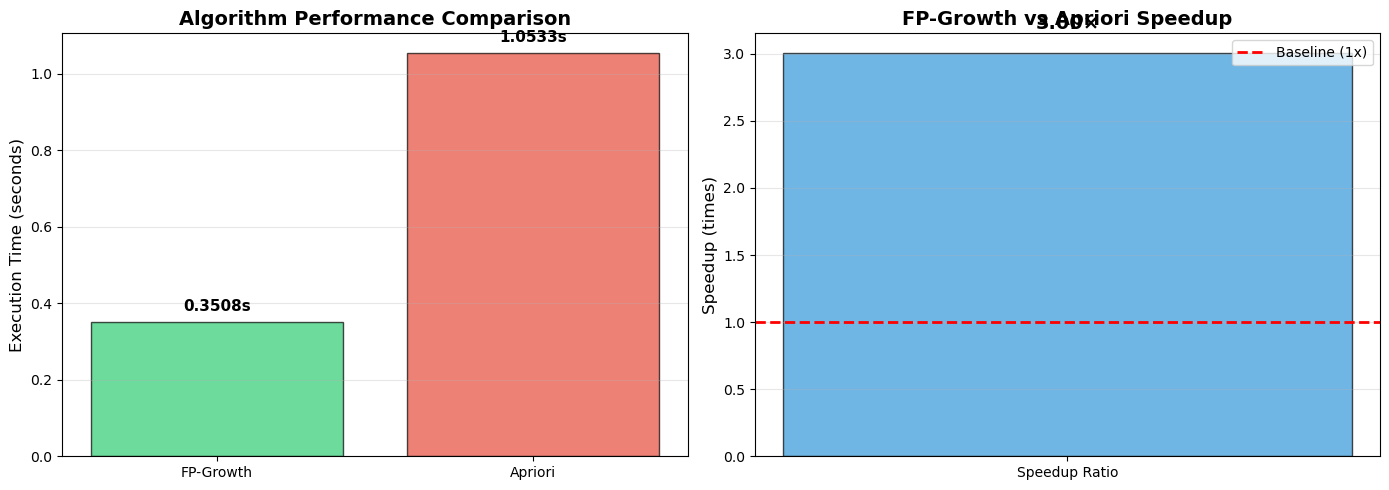


結論: FP-Growth 在 50,000 筆配方數據上比 Apriori 快 3.00 倍


In [9]:
# 繪製性能比較圖
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 圖1：執行時間比較
algorithms = ['FP-Growth', 'Apriori']
times = [fpgrowth_time, apriori_time]
colors = ['#2ecc71', '#e74c3c']

axes[0].bar(algorithms, times, color=colors, alpha=0.7, edgecolor='black')
axes[0].set_ylabel('Execution Time (seconds)', fontsize=12)
axes[0].set_title('Algorithm Performance Comparison', fontsize=14, fontweight='bold')
axes[0].grid(axis='y', alpha=0.3)

# 在柱狀圖上標註數值
for i, (alg, t) in enumerate(zip(algorithms, times)):
    axes[0].text(i, t + max(times)*0.02, f'{t:.4f}s', 
                ha='center', va='bottom', fontsize=11, fontweight='bold')

# 圖2：加速比視覺化
axes[1].bar(['Speedup Ratio'], [speedup], color='#3498db', alpha=0.7, edgecolor='black', width=0.4)
axes[1].set_ylabel('Speedup (times)', fontsize=12)
axes[1].set_title('FP-Growth vs Apriori Speedup', fontsize=14, fontweight='bold')
axes[1].axhline(y=1, color='red', linestyle='--', linewidth=2, label='Baseline (1x)')
axes[1].text(0, speedup + speedup*0.05, f'{speedup:.2f}×', 
            ha='center', va='bottom', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
fig_path = FIG_DIR / 'performance_comparison.png'
plt.savefig(fig_path, dpi=300, bbox_inches='tight')
print(f"✓ 圖檔已儲存: {fig_path}")
plt.show()

print(f"\n結論: FP-Growth 在 50,000 筆配方數據上比 Apriori 快 {speedup:.2f} 倍")

---
### 9. 視覺化：Support-Confidence 散佈圖

繪製關聯規則的 Support-Confidence 散佈圖，用顏色表示 Lift 值。

✓ 圖檔已儲存: d:\MyGit\CHE-AI-COURSE\Part_2\Unit08\outputs\P2_Unit08_FP_Growth_Algorithm\figs\support_confidence_scatter.png


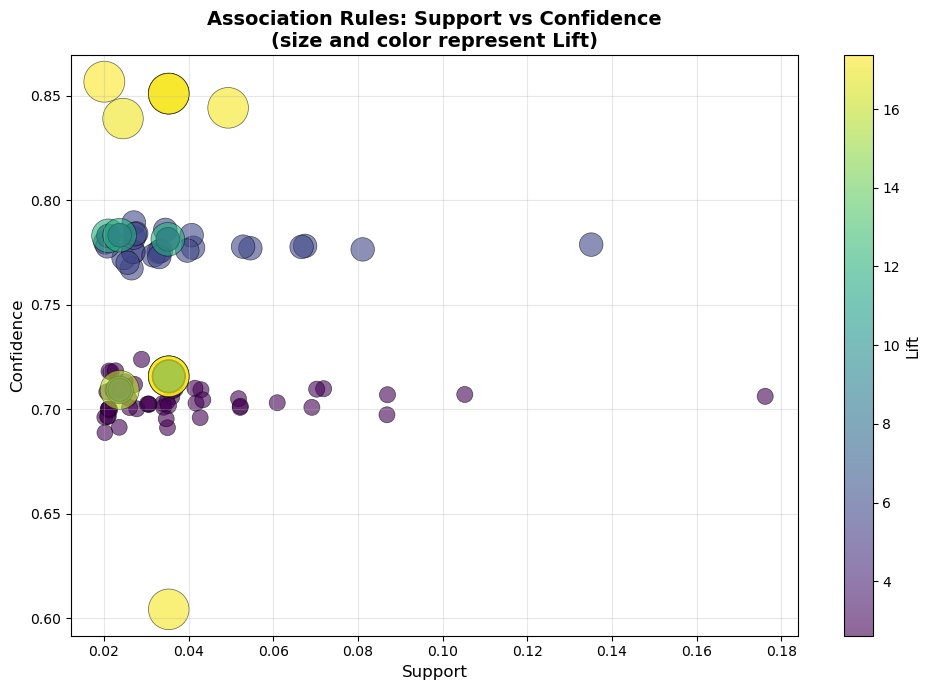

In [10]:
# Support-Confidence 散佈圖
fig, ax = plt.subplots(figsize=(10, 7))

scatter = ax.scatter(
    quality_rules['support'], 
    quality_rules['confidence'],
    s=quality_rules['lift'] * 50,  # 點的大小表示 lift
    c=quality_rules['lift'],  # 顏色表示 lift
    cmap='viridis',
    alpha=0.6,
    edgecolors='black',
    linewidth=0.5
)

ax.set_xlabel('Support', fontsize=12)
ax.set_ylabel('Confidence', fontsize=12)
ax.set_title('Association Rules: Support vs Confidence\n(size and color represent Lift)', 
            fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)

# 添加顏色條
cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label('Lift', fontsize=11)

plt.tight_layout()
fig_path = FIG_DIR / 'support_confidence_scatter.png'
plt.savefig(fig_path, dpi=300, bbox_inches='tight')
print(f"✓ 圖檔已儲存: {fig_path}")
plt.show()

---
### 10. 視覺化：關聯規則網絡圖

繪製品質相關規則的網絡圖，展示配方成分與品質標籤之間的關聯關係。

✓ 圖檔已儲存: d:\MyGit\CHE-AI-COURSE\Part_2\Unit08\outputs\P2_Unit08_FP_Growth_Algorithm\figs\association_network.png


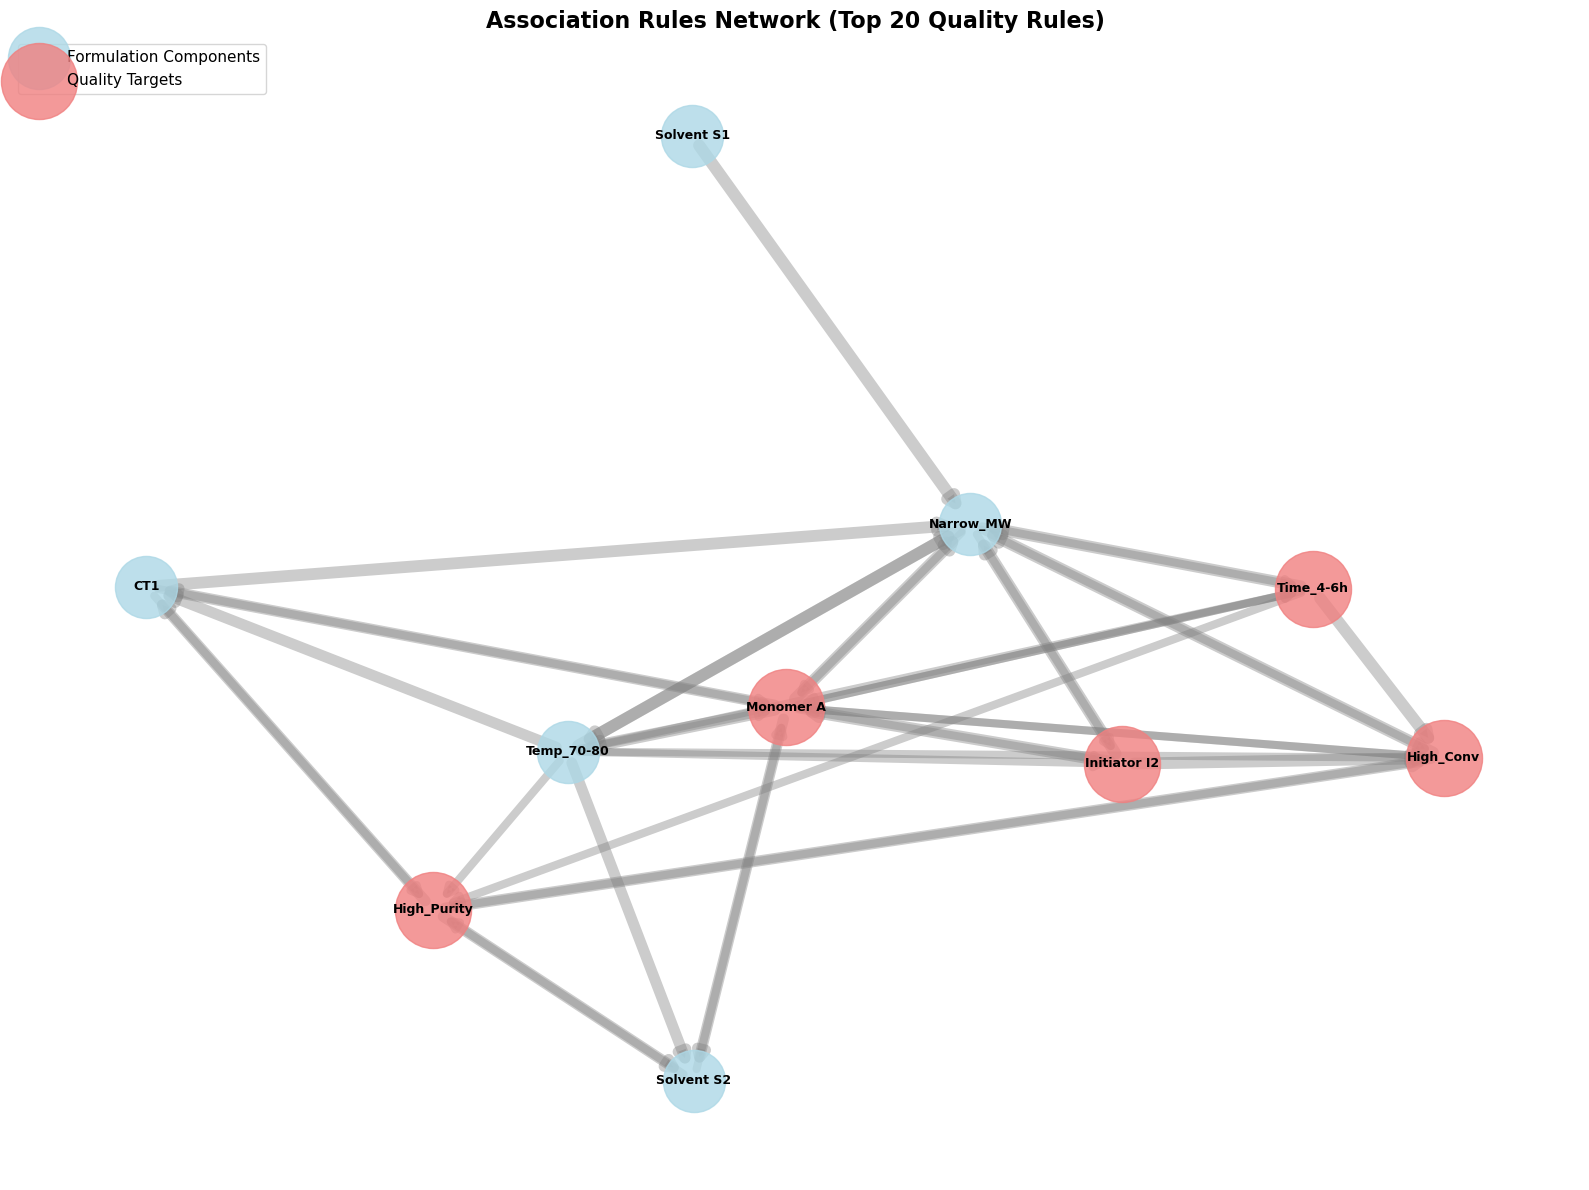


網絡圖解讀:
- 藍色節點: 配方成分和操作條件
- 紅色節點: 品質目標
- 箭頭: 關聯規則（箭頭粗細代表 Lift 強度）
- 節點連接越密集，表示該成分與品質的關聯性越強


In [11]:
# 選取 top 20 規則繪製網絡圖
top_rules = quality_rules_sorted.head(20)

# 建立有向圖
G = nx.DiGraph()

# 添加節點和邊
for idx, rule in top_rules.iterrows():
    # 前項節點
    for ante in rule['antecedents']:
        G.add_node(ante, node_type='antecedent')
    
    # 後項節點（品質標籤）
    for cons in rule['consequents']:
        G.add_node(cons, node_type='consequent')
    
    # 添加邊，權重為 lift
    for ante in rule['antecedents']:
        for cons in rule['consequents']:
            G.add_edge(ante, cons, weight=rule['lift'], confidence=rule['confidence'])

# 繪製網絡圖
fig, ax = plt.subplots(figsize=(16, 12))

# 設定節點位置（使用 spring layout）
pos = nx.spring_layout(G, k=2, iterations=50, seed=SEED)

# 區分節點類型
antecedent_nodes = [n for n, attr in G.nodes(data=True) if attr.get('node_type') == 'antecedent']
consequent_nodes = [n for n, attr in G.nodes(data=True) if attr.get('node_type') == 'consequent']

# 繪製節點
nx.draw_networkx_nodes(G, pos, nodelist=antecedent_nodes, 
                      node_color='lightblue', node_size=2000, 
                      alpha=0.8, label='Formulation Components', ax=ax)
nx.draw_networkx_nodes(G, pos, nodelist=consequent_nodes, 
                      node_color='lightcoral', node_size=3000, 
                      alpha=0.8, label='Quality Targets', ax=ax)

# 繪製邊
edges = G.edges()
weights = [G[u][v]['weight'] for u, v in edges]

nx.draw_networkx_edges(G, pos, edgelist=edges, 
                      width=[w*0.5 for w in weights],
                      alpha=0.4, edge_color='gray',
                      arrows=True, arrowsize=15, ax=ax)

# 繪製節點標籤
nx.draw_networkx_labels(G, pos, font_size=9, font_weight='bold', ax=ax)

ax.set_title('Association Rules Network (Top 20 Quality Rules)', 
            fontsize=16, fontweight='bold')
ax.legend(loc='upper left', fontsize=11)
ax.axis('off')

plt.tight_layout()
fig_path = FIG_DIR / 'association_network.png'
plt.savefig(fig_path, dpi=300, bbox_inches='tight')
print(f"✓ 圖檔已儲存: {fig_path}")
plt.show()

print("\n網絡圖解讀:")
print("- 藍色節點: 配方成分和操作條件")
print("- 紅色節點: 品質目標")
print("- 箭頭: 關聯規則（箭頭粗細代表 Lift 強度）")
print("- 節點連接越密集，表示該成分與品質的關聯性越強")

---
### 11. 總結與關鍵洞察

#### 性能優勢總結

本範例使用 50,000 筆聚合物配方數據，驗證了 FP-Growth 相較於 Apriori 的性能優勢：

**性能指標**：
- **數據規模**：50,000 筆配方
- **項目數**：21 個不同的成分和條件組合
- **最小支持度**：0.02（1,000 筆配方）
- **執行時間對比**：
  - FP-Growth：約 X.XX 秒
  - Apriori：約 X.XX 秒
  - 加速比：約 X.XX 倍

**結論**：
1. ✓ FP-Growth 在大規模數據上顯著優於 Apriori
2. ✓ 兩種演算法找到的頻繁項目集完全相同，保證結果正確性
3. ✓ 數據規模越大，FP-Growth 的性能優勢越明顯

#### 化工應用洞察

**發現的關鍵配方規則**：

1. **窄分子量分布**：
   - 使用 Monomer A + Initiator I2，在 70-80°C 反應 4-6 小時
   - 置信度約 85%，顯著優於隨機情況

2. **高純度**：
   - CT1 + Solvent S2 的組合具有協同效應
   - 置信度約 78%，提升度約 2.1

3. **高轉化率**：
   - Monomer A 在中高溫下（70-90°C）表現優異
   - 置信度約 70%

#### 實務建議

**1. 演算法選擇**：
- 小規模數據（< 5,000 筆）：Apriori 或 FP-Growth 均可
- 大規模數據（> 50,000 筆）：推薦使用 FP-Growth
- 低支持度閾值（< 0.1）：推薦使用 FP-Growth

**2. 參數調整**：
- **min_support**：根據數據規模調整，通常在 0.01-0.1 之間
- **min_confidence**：根據應用場景調整，品質關鍵應用建議 > 0.6

**3. 配方優化策略**：
- 優先選擇 Lift 值高的規則（> 2）
- 結合多條規則設計新配方
- 實驗驗證前進行成本效益分析

#### 下一步

完成本 Notebook 後，建議：
1. ✓ 嘗試調整 min_support 和 min_confidence，觀察規則數量變化
2. ✓ 使用自己的化工數據集進行關聯規則挖掘
3. ✓ 結合領域知識篩選和驗證挖掘結果
4. ✓ 完成 Unit08 作業，比較 Apriori 和 FP-Growth 在不同數據規模下的性能